In [2]:
import transformers
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast
import pandas as pd
import warnings
import re
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import numpy as np
import mplcursors

In [16]:
class FineTunedBERT(nn.Module):

    def __init__(self, pool="mean"):
      
        super(FineTunedBERT, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-cased")
        self.pool = pool
        
    def forward(self, input_ids_, attention_mask_):
        

        #pass the inputs to the model
        hiddenState, ClsPooled = self.bert(input_ids = input_ids_,
                              attention_mask=attention_mask_).values()
        
            
        if self.pool.lower() == "max":
            pooled_embeddings = self.max_pooling(hiddenState, attention_mask_)
            
        elif self.pool.lower() == "cls":
            pooled_embeddings = ClsPooled
            
        elif self.pool.lower() == "mean":
            pooled_embeddings = self.mean_pooling(hiddenState, attention_mask_)

        else:
            raise ValueError('Pooling value error.')

        
        return pooled_embeddings, hiddenState

    def max_pooling(self, hidden_state, attention_mask):
        
        #CLS: First element of model_output contains all token embeddings
        token_embeddings = hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
        
        pooled_embeddings = torch.max(token_embeddings, 1)[0]
        return pooled_embeddings
    
    def mean_pooling (self, hidden_state, attention_mask):
        
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_state.size()).float()
        pooled_embeddings = torch.sum(hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9) 
        
        return pooled_embeddings


In [4]:
def process_sent(sent):

    pattern1 = r'(?:"(.*?)"|\'(.*?)\')'
    pattern2 = r"\[provided by .*?\]"
    pattern3 = r"\(PubMed:\d+(?:\s+\d+)*\)"
    pattern4 = r"\(\s+[\w\s]+\s+[\w]+\s+\)"
    pattern5 = r"\s*\(Microbial infection\)"
    pattern6 = r"\[(Isoform [^\]]+)\]:\s*"
    pattern7 = r"\(By similarity\)"

    matches = re.findall(pattern1, sent)
    captured_content = [match[0] if match[0] else match[1] for match in matches]
    text = " ".join(captured_content)
    text = re.sub(pattern2, "", text)
    text = re.sub(pattern3, "####", text)
    text = re.sub(pattern4, "", text)
    text = re.sub(pattern5, "", text)
    text = re.sub(pattern6, r"\1 ", text)
    text = re.sub(pattern7, "", text)
    text = re.sub(r'\s+', ' ', text)
    
    return text
    

def getSentenceEmbeddings(sentences, max_length=512, batch_size=1000, pool ="mean"):
    
    

    model = FineTunedBERT(pool= pool)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

    print("Perform tokenization ...")
    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length,
                                         padding="max_length",truncation=True,
                                         return_tensors="pt")
    
    
    dataset = TensorDataset(tokens["input_ids"] , tokens["attention_mask"])
    dataloader = DataLoader(dataset, batch_size=batch_size)

    print("Tokenization Done.")
    
    print("Get embeddings ...")
    
    embeddings=[]
    model.eval()
    for batch_input_ids, batch_attention_mask in tqdm(dataloader):
        with torch.no_grad():
            pooled_embeddings, _ = model(batch_input_ids , batch_attention_mask)
            embeddings.append(pooled_embeddings)
    
    
    concat_embeddings = torch.cat(embeddings, dim=0)
    
    print(concat_embeddings.size())
    
    return concat_embeddings
    

In [5]:
genes = pd.read_csv("data/genes.csv")
genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
genes = genes.drop_duplicates(subset='Summary').reset_index(drop=True)
genes

,Gene name,Summary,Interactions
0,FES,This gene encodes the human cellular counterpa...,Homooligomer.Interacts with BCR.Interacts (whe...
1,HADHA,This gene encodes the alpha subunit of the mit...,NaN
2,SLC7A7,The protein encoded by this gene is the light ...,NaN
3,LCK,This gene is a member of the Src family of pro...,NaN
4,HSPA2,Enables disordered domain specific binding act...,NaN
...,...,...,...
16035,ENSG00000288681,ENSG00000288681 (Novel Protein) is a Protein C...,NaN
16036,BPY2C,This gene is located in the nonrecombining por...,Interacts with MAP1S.Interacts with UBE3A (via...
16037,DNER,The protein encoded by this gene is a cofactor...,Forms a 1:1 stoichiometric complex with pancre...
16038,SOX7,Predicted to enable Notch binding activity. In...,Interacts with AP1G1.Interacts with NOTCH1 (By...


In [44]:
genes["Summary"].loc[0]

'This gene encodes the human cellular counterpart of a feline sarcoma retrovirus protein with transforming capabilities. The gene product has tyrosine-specific protein kinase activity and that activity is required for maintenance of cellular transformation. Its chromosomal location has linked it to a specific translocation event identified in patients with acute promyelocytic leukemia but it is also involved in normal hematopoiesis as well as growth factor and cytokine receptor signaling. Alternative splicing results in multiple variants encoding different isoforms. FES (FES Proto-Oncogene Tyrosine Kinase) is a Protein Coding gene. Diseases associated with FES include Sarcoma and Myeloid Leukemia. Among its related pathways are Semaphorin interactions and Nervous system development. Gene Ontology (GO) annotations related to this gene include transferase activity transferring phosphorus-containing groups and protein tyrosine kinase activity. An important paralog of this gene is FER. Tyr

[nltk_data] Downloading package punkt to /users/jararweh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


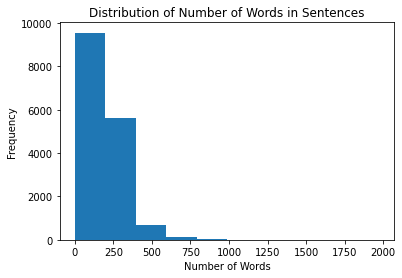

In [201]:

num_words_per_sentence = [len(word_tokenize(sentence)) for sentence in genes["Summary"]]

plt.hist(num_words_per_sentence)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Sentences')
plt.show()

# Pooling (mean):
- This pooling is for tokens in a sentence. BERT returns an embedding for each word(token) in a sentence. To get the entire sentence embedding, we perform pooling on tokens.

- To get the embedding for a list of sentences in a paragraph, a second pooling should be performed.

CAVEAT: The summaries were truncated to 512 tokens(app. 512 words).

In [7]:
pooled_embeddings= getSentenceEmbeddings(genes["Summary"].tolist(), pool="mean", batch_size=500)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform tokenization ...
Tokenization Done.
Get embeddings ...


100%|██████████| 33/33 [13:57<00:00, 25.38s/it]


torch.Size([16040, 768])


In [8]:
#%matplotlib notebook
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

tsne = TSNE(n_components=2)
scaler = StandardScaler()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    latents_tsne = tsne.fit_transform(pooled_embeddings.detach().numpy())

In [28]:
#np.save("data/tsne_embeddings.npy", latents_tsne)
#latents_tsne = np.load("data/tsne_embeddings.npy")

<IPython.core.display.Javascript object>


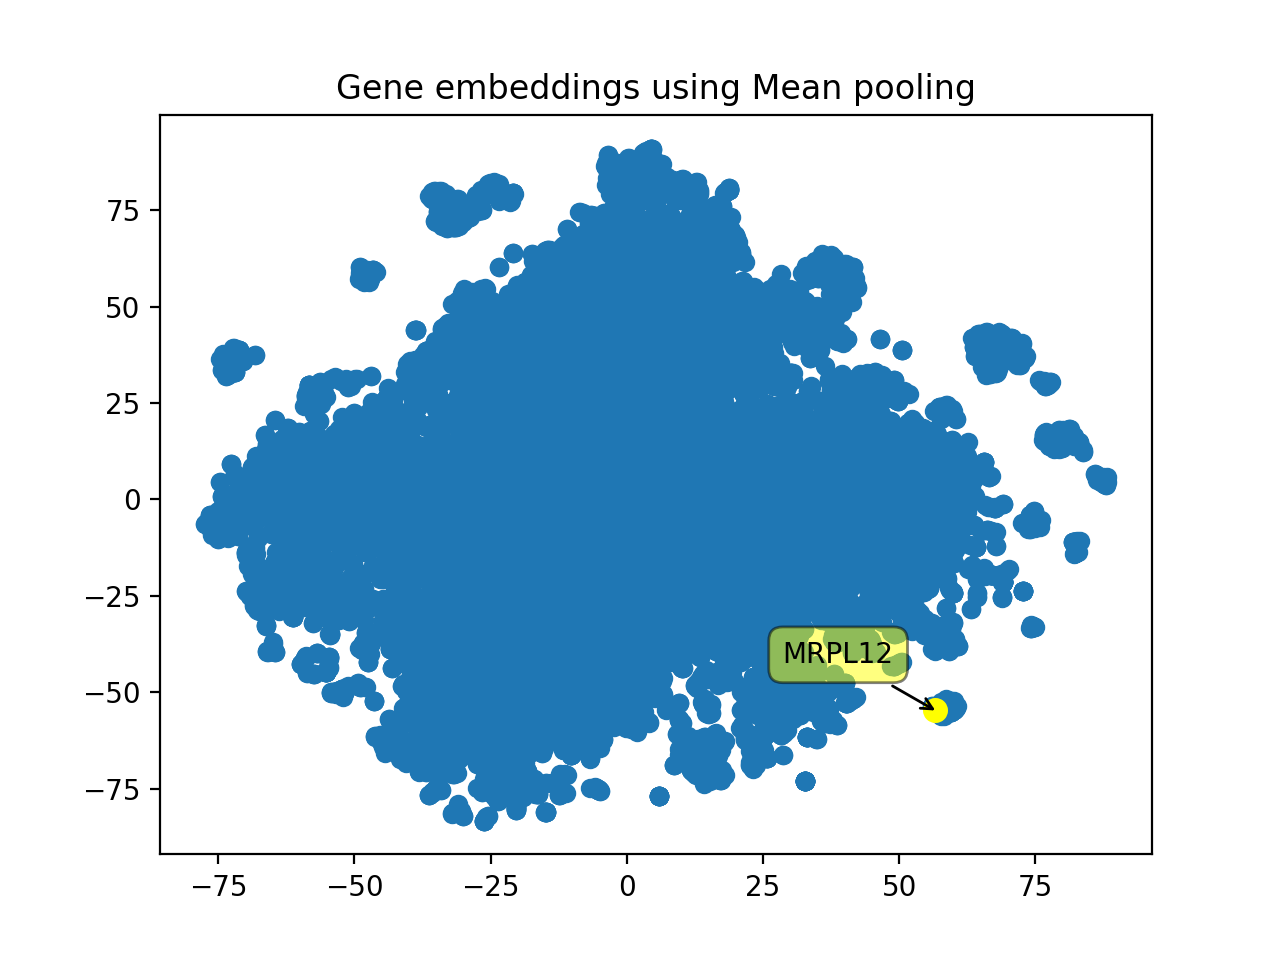

In [12]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(latents_tsne[:, 0], latents_tsne[:, 1])
ax.set_title('Gene embeddings using Mean pooling')
crs = mplcursors.cursor(ax,highlight=True)
crs.connect("add", lambda sel: sel.annotation.set_text(genes["Gene name"][sel.index]))

plt.show()

# Pooling (CLS):
- This pooling is for tokens in a sentence. BERT returns an embedding for each word(token) in a sentence. To get the entire sentence embedding, we perform pooling on tokens.

- To get the embedding for a list of sentences in a paragraph, a second pooling should be performed.

CAVEAT: The summaries were truncated to 512 tokens(app. 512 words).

In [21]:
pooled_embeddings= getSentenceEmbeddings(genes["Summary"].tolist(), pool="cls", batch_size=500)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform tokenization ...
Tokenization Done.
Get embeddings ...


100%|██████████| 33/33 [13:53<00:00, 25.27s/it]


torch.Size([16040, 768])


In [42]:
#filename = 'data/reconstructed_data.json'
# with open(filename, 'w') as file:
#     json.dump(dataset_reconstructed, file)

768

<IPython.core.display.Javascript object>


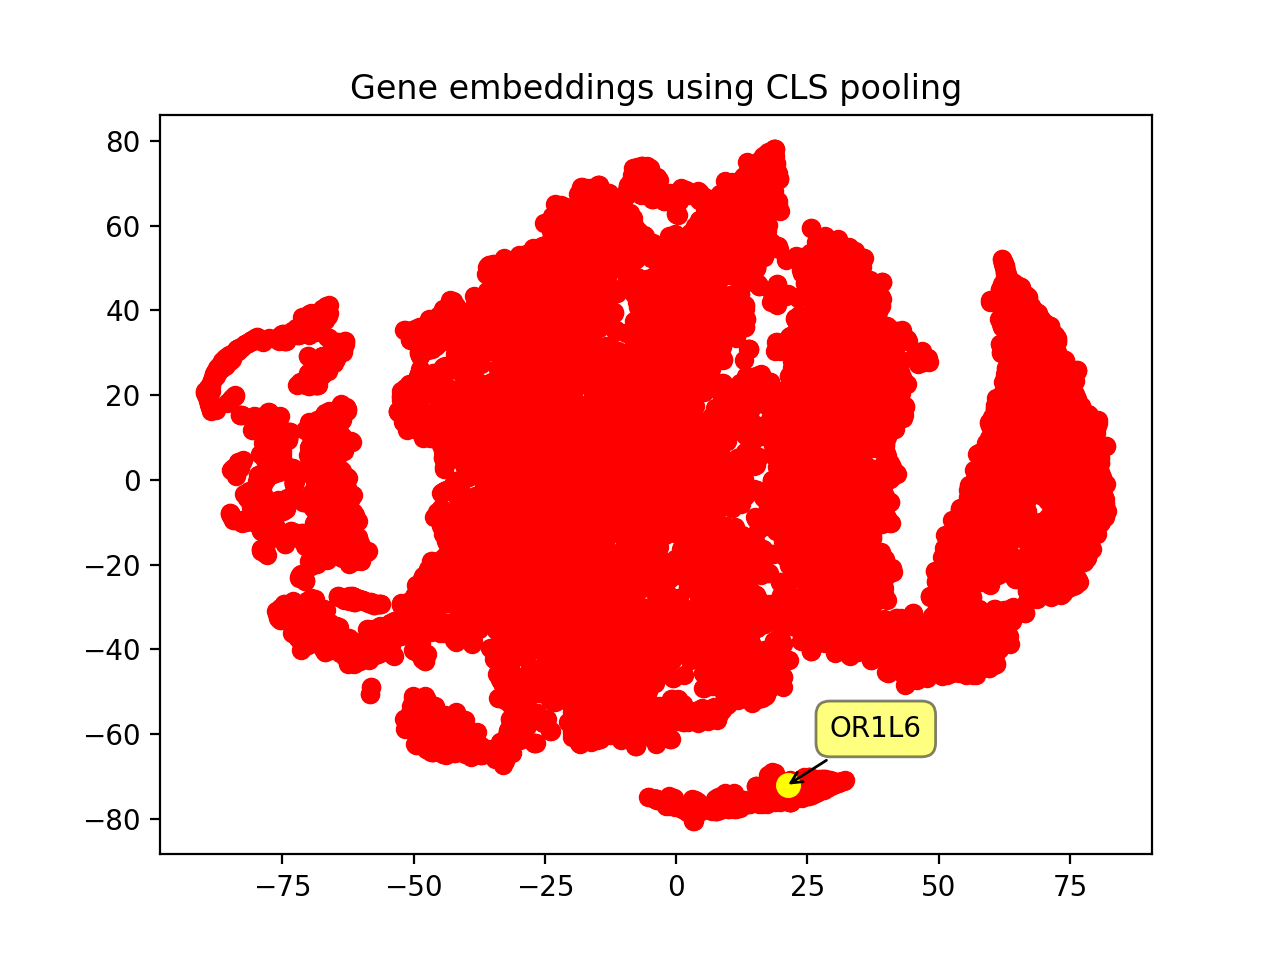

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    latents_tsne = tsne.fit_transform(pooled_embeddings.detach().numpy())
    
fig2, ax2 = plt.subplots()
ax2.scatter(latents_tsne[:, 0], latents_tsne[:, 1], color='red')
ax2.set_title('Gene embeddings using CLS pooling')
crs2 = mplcursors.cursor(ax2, highlight=True)
crs2.connect("add", lambda sel: sel.annotation.set_text(genes["Gene name"][sel.index]))

plt.show()

In [17]:
pooled_embeddings= getSentenceEmbeddings(genes["Summary"].tolist(), pool="max", batch_size=500)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform tokenization ...
Tokenization Done.
Get embeddings ...


100%|██████████| 33/33 [13:55<00:00, 25.31s/it]


torch.Size([16040, 768])


In [ ]:
[1 2] -> w1
[2 0] -> w2

[2 2]

<IPython.core.display.Javascript object>


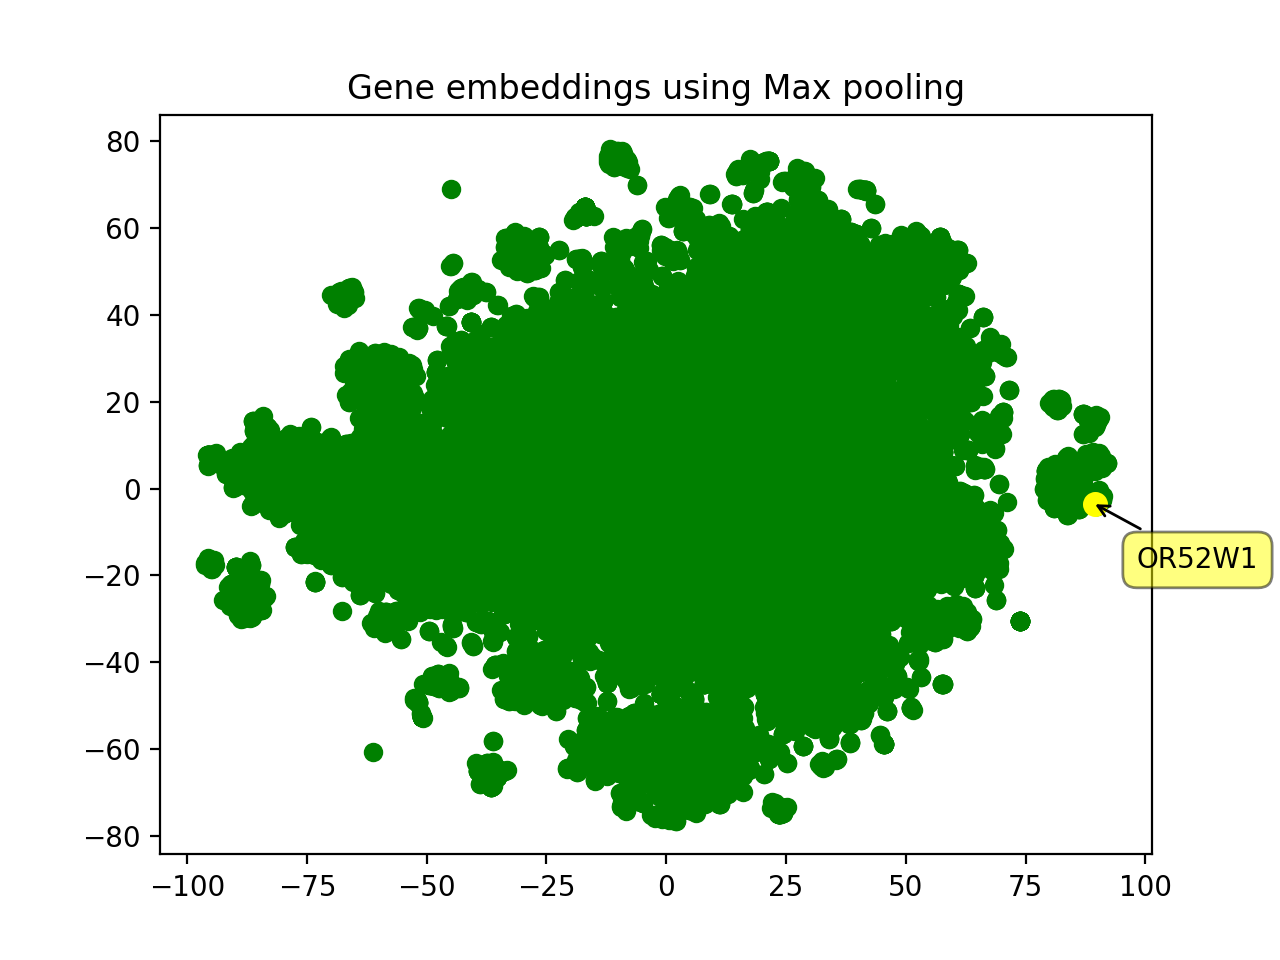

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    latents_tsne = tsne.fit_transform(pooled_embeddings.detach().numpy())
    
fig3, ax3 = plt.subplots()
ax3.scatter(latents_tsne[:, 0], latents_tsne[:, 1], color='green')
ax3.set_title('Gene embeddings using Max pooling')
crs3= mplcursors.cursor(ax3, highlight=True)
crs3.connect("add", lambda sel: sel.annotation.set_text(genes["Gene name"][sel.index]))

plt.show()

In [187]:
import ast
import re

for i in range (len(df["Summary"])):
    
    sent = df["Summary"][i]
    pattern1 = r'(?:"(.*?)"|\'(.*?)\')'
    pattern2 = r"\[provided by .*?\]"
    pattern3 = r"\(PubMed:\d+(?:\s+\d+)*\)"
    pattern4 = r"\(\s+[\w\s]+\s+[\w]+\s+\)"
    pattern5 = r"\s*\(Microbial infection\)"
    pattern6 = r"\[(Isoform [^\]]+)\]:\s*"
    pattern7 = r"\(By similarity\)"

    matches = re.findall(pattern1, sent)
    captured_content = [match[0] if match[0] else match[1] for match in matches]
    sentences = " ".join(captured_content)
    sentences = re.sub(pattern2, "", sentences)
    sentences = re.sub(pattern3, "####", sentences)
    sentences = re.sub(pattern4, "", sentences)
    sentences = re.sub(pattern5, "", sentences)
    sentences = re.sub(pattern6, r"\1 ", sentences)
    sentences = re.sub(pattern7, "", sentences)
    sentences = re.sub(r'\s+', ' ', sentences)
    

    if len(sentences.split("                  "))>2:
        print(df["Gene name"][i])
        print(i)
        print(sentences)
        print("-"*60)
